In [1]:
%cd C:\Users\cuihaoxuan\Documents\SeeU\Python Bootcamp\2022 Python Bootcamp

C:\Users\cuihaoxuan\Documents\SeeU\Python Bootcamp\2022 Python Bootcamp


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

%pip install -U imbalanced-learn

from imblearn.over_sampling import SMOTE 

Note: you may need to restart the kernel to use updated packages.


In [3]:
df_train = pd.read_csv('aug_train.csv')
df_test = pd.read_csv('aug_test.csv')
df_test_target = pd.read_csv('sample_submission.csv')


In [4]:
df_test_comb = pd.merge(df_test,df_test_target,on='enrollee_id',how='inner')
df = df_train.append(df_test_comb)# append is y axis add, merge is x axis add
df_raw = df.copy()
#test target only has enrolle id and target, combine is with test(inner: combine the ones that are the same)

In [5]:
df_raw.shape

(21287, 14)

In [6]:
for x in df.columns:
    print('-----COLUMNS-----', x)
    print(df[x].dtype)
    print(df[x].unique().tolist()[:20]) #lots of unique value under each columns just look at the first 20
# understand the feature and values for all the columns

-----COLUMNS----- enrollee_id
int64
[8949, 29725, 11561, 33241, 666, 21651, 28806, 402, 27107, 699, 29452, 23853, 25619, 5826, 8722, 6588, 4167, 5764, 2156, 11399]
-----COLUMNS----- city
object
['city_103', 'city_40', 'city_21', 'city_115', 'city_162', 'city_176', 'city_160', 'city_46', 'city_61', 'city_114', 'city_13', 'city_159', 'city_102', 'city_67', 'city_100', 'city_16', 'city_71', 'city_104', 'city_64', 'city_101']
-----COLUMNS----- city_development_index
float64
[0.92, 0.7759999999999999, 0.624, 0.789, 0.767, 0.764, 0.762, 0.913, 0.926, 0.8270000000000001, 0.843, 0.804, 0.855, 0.887, 0.91, 0.884, 0.924, 0.6659999999999999, 0.5579999999999999, 0.923]
-----COLUMNS----- gender
object
['Male', nan, 'Female', 'Other']
-----COLUMNS----- relevent_experience
object
['Has relevent experience', 'No relevent experience']
-----COLUMNS----- enrolled_university
object
['no_enrollment', 'Full time course', nan, 'Part time course']
-----COLUMNS----- education_level
object
['Graduate', 'Masters

# Explore and identify preprocessing steps¶

## (to find feature's correlation, null value or outlier)

In [7]:
df.isnull().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    5016
relevent_experience          0
enrolled_university        417
education_level            512
major_discipline          3125
experience                  70
company_size              6560
company_type              6774
last_new_job               463
training_hours               0
target                       0
dtype: int64

In [8]:
# count of missing value per row
missing_value_row = pd.DataFrame(df.isnull().sum(axis=1))
missing_value_row[0].value_counts()

0    9974
1    4152
2    4030
3    2168
4     688
5     195
6      66
7      14
Name: 0, dtype: int64

In [9]:
# examine the row that has way too many missing value
missing_value_row[missing_value_row[0]==7]

,0
1376,7
2518,7
7746,7
8905,7
9206,7
10337,7
11789,7
12079,7
12348,7
13236,7


In [10]:
# drop the row if less than 10 non-null value . 14 total column - 5missing colum = 9 , 9+1 = 10 at least 10 non-missing value
# remove 250 records thats has more than 5 missing value in a record
df.dropna(axis=0, thresh=10, inplace=True) # drop the row, at least 10 non missing value

In [11]:
df.shape

(21012, 14)

In [12]:
# save as dictionary of each city counts, easier to see too
city_dict = df['city'].value_counts().to_dict()
df['city'].nunique()

123

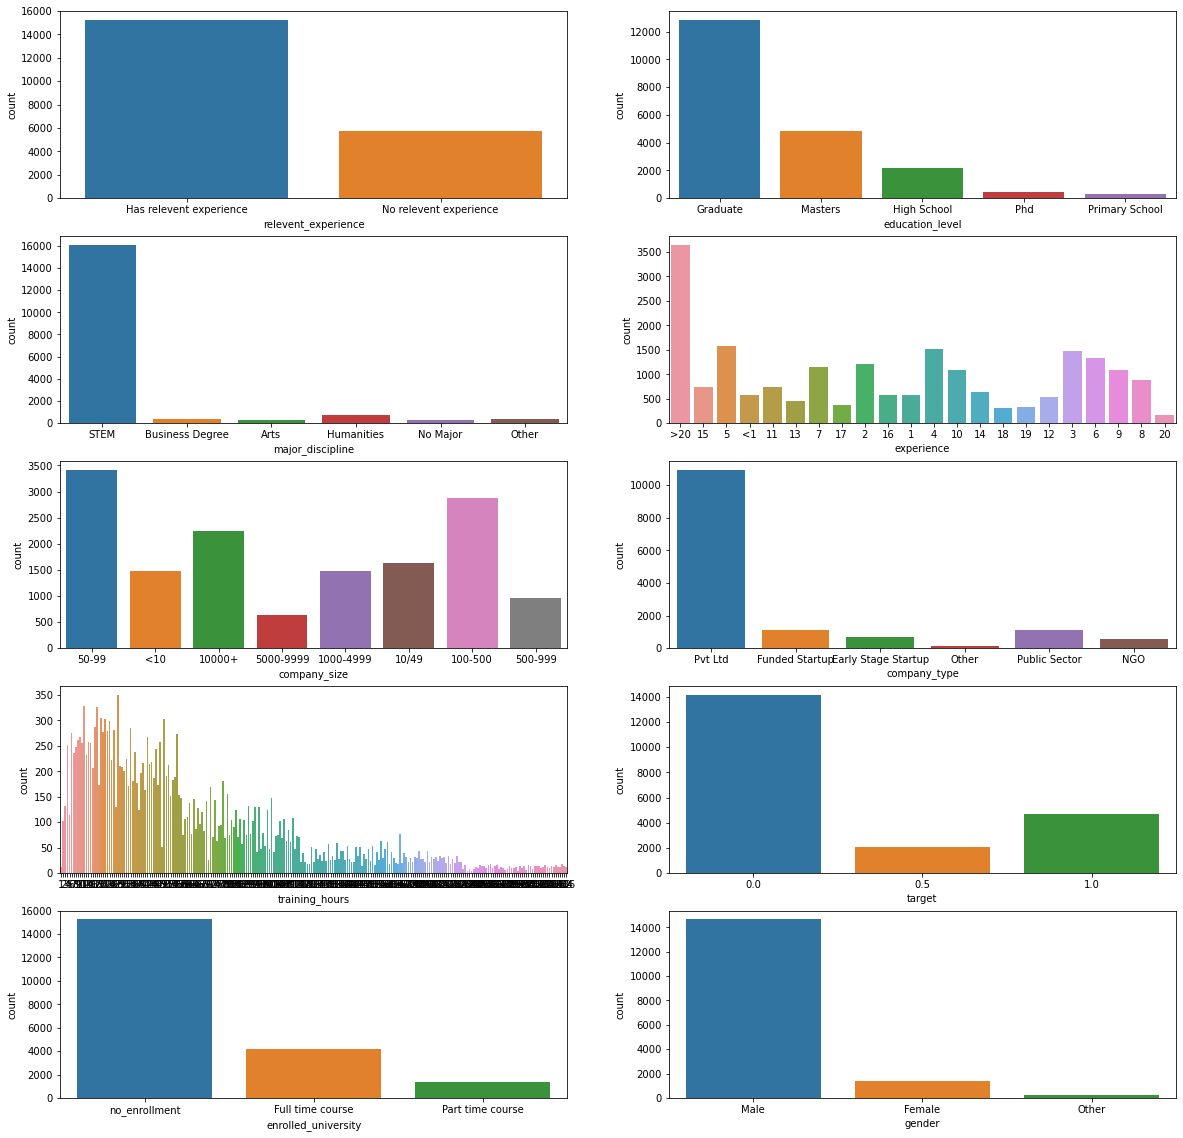

In [13]:
# plot counts of value in selected column
plt.figure(figsize=[20,20])
col = ['relevent_experience','education_level','major_discipline','experience', 'company_size', 'company_type',
       'training_hours', 'target','enrolled_university', 'gender']

n=1
for col_name in col:
    plt.subplot(5,2,n)
    sns.countplot(x=col_name,data=df)
    #plt.title(f"{col_name} Distribution") 
    n=n+1
    
plt.show()

# City

In [14]:
## Binning , categorize all count of candidate <=50 as one group'small_city'
lst_small_city=[]
lst_med_city=[]
lst_large_city=[]
lst_superlarge_city=[]
for key,value in city_dict.items():
    if value <=50:
        lst_small_city.append(key)
    if value >50 and value <=100:
        lst_med_city.append(key)
    if value >100 and value <=200:
        lst_large_city.append(key)
    else:
        lst_superlarge_city.append(key)

In [15]:
# replace those small city name as 'city_small'

df.loc[df['city'].isin(lst_small_city) , 'city'] = 'city_small'
df.loc[df['city'].isin(lst_med_city) , 'city'] = 'city_med'
df.loc[df['city'].isin(lst_large_city) , 'city'] = 'city_large'
df.loc[df['city'].isin(lst_superlarge_city) , 'city'] = 'city_xlarge'

In [16]:
df.city.value_counts()

city_xlarge    15761
city_large      2723
city_med        1375
city_small      1153
Name: city, dtype: int64

In [17]:
le = LabelEncoder().fit(df['city'])
CityList = le.classes_
df['city'] = le.transform(df['city'])

In [18]:
# Keep the record of labeling
dict(zip(le.classes_, le.transform(le.classes_)))

{'city_large': 0, 'city_med': 1, 'city_small': 2, 'city_xlarge': 3}

# Gender

In [19]:
#gender
df.gender.value_counts()

Male      14641
Female     1374
Other       210
Name: gender, dtype: int64

In [20]:
df[df.gender.isna()]

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
2,11561,3,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,1,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
5,21651,2,0.764,NaN,Has relevent experience,Part time course,Graduate,STEM,11,NaN,NaN,1,24,1.0
9,699,3,0.920,NaN,Has relevent experience,no_enrollment,Graduate,STEM,17,10000+,Pvt Ltd,>4,123,0.0
10,29452,3,0.624,NaN,No relevent experience,Full time course,High School,NaN,2,NaN,NaN,never,32,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2107,19678,3,0.910,NaN,Has relevent experience,no_enrollment,Graduate,STEM,>20,<10,Pvt Ltd,never,138,0.5
2110,22744,1,0.698,NaN,Has relevent experience,no_enrollment,Masters,STEM,15,50-99,Pvt Ltd,>4,157,0.5
2114,6294,3,0.754,NaN,Has relevent experience,no_enrollment,High School,NaN,>20,50-99,Pvt Ltd,2,31,0.5
2119,8905,2,0.698,NaN,No relevent experience,Full time course,High School,NaN,8,NaN,NaN,never,55,0.5


<AxesSubplot:xlabel='enrolled_university,education_level,major_discipline'>

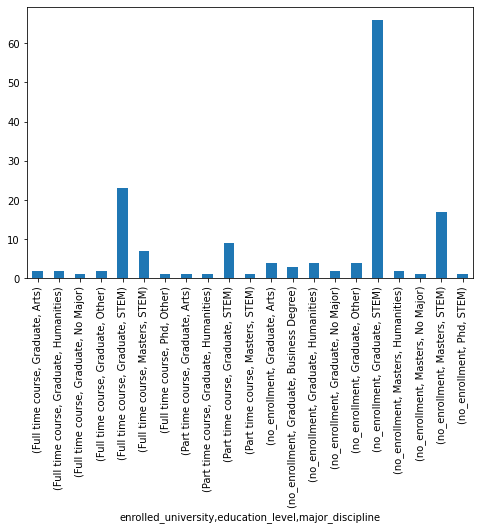

In [21]:
# show the counts of each group when gender is 'Other'
group = df[df['gender']=='Other'].groupby(['enrolled_university', 'education_level', 'major_discipline']).size()
figure(figsize=(8,5))
group.plot.bar()

<AxesSubplot:xlabel='enrolled_university,education_level,major_discipline'>

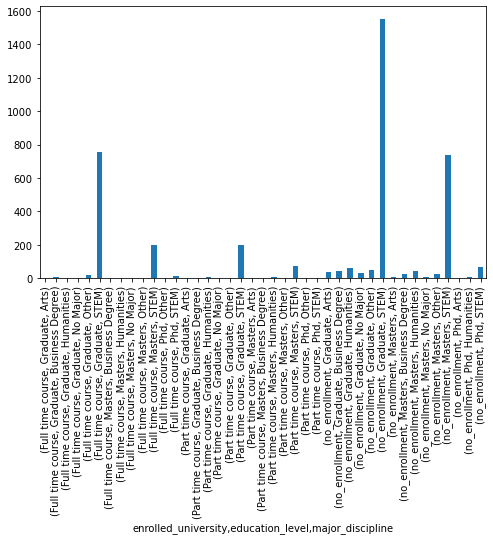

In [22]:
# show the counts of each group when gender is null 
group = df[df['gender'].isna()].groupby(['enrolled_university', 'education_level', 'major_discipline']).size()
figure(figsize=(8,5))
group.plot.bar()

In [23]:
# replace the null value of gender to 'Other', because based on the
df['gender'].fillna('Other' ,inplace=True)

In [24]:
le_gender = LabelEncoder().fit(df['gender'])
df['gender'] = le_gender.transform(df['gender'])

# Relative Experience

In [25]:
# convert to binary 0 and 1, no nan since (dropna is false)
df.relevent_experience.value_counts(dropna=False)

Has relevent experience    15251
No relevent experience      5761
Name: relevent_experience, dtype: int64

In [26]:
#show percentage of all values in percentage(normalize)
df.enrolled_university.value_counts(dropna=False,normalize=True)

no_enrollment       0.725300
Full time course    0.197459
Part time course    0.063345
NaN                 0.013897
Name: enrolled_university, dtype: float64

In [27]:
le = preprocessing.LabelEncoder()
le.fit_transform(df['relevent_experience'])

array([0, 1, 1, ..., 1, 0, 0])

In [28]:
#change the original data set sring to number
df['relevent_experience']=le.fit_transform(df['relevent_experience'])

In [29]:
# create a label encoding reference 
dict(zip(le.classes_,le.transform(le.classes_))) # zip aggregate two list into a tuple

{'Has relevent experience': 0, 'No relevent experience': 1}

In [30]:
df

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,3,0.920,1,0,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,1,0.776,1,1,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,3,0.624,2,1,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,1,0.789,2,1,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,0,0.767,1,0,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,1289,3,0.920,1,1,no_enrollment,Graduate,Humanities,16,NaN,Public Sector,4,15,0.5
2125,195,3,0.897,1,0,no_enrollment,Masters,STEM,18,NaN,NaN,2,30,0.5
2126,31762,3,0.887,1,1,no_enrollment,Primary School,NaN,3,NaN,Pvt Ltd,never,18,0.5
2127,7873,3,0.804,1,0,Full time course,High School,NaN,7,100-500,Public Sector,1,84,0.5


# enrolled university

In [31]:
df.enrolled_university.value_counts(dropna=False,normalize=True)

no_enrollment       0.725300
Full time course    0.197459
Part time course    0.063345
NaN                 0.013897
Name: enrolled_university, dtype: float64

In [32]:
le_enrolled_university = LabelEncoder().fit(df['enrolled_university'])
df['enrolled_university'] = le_enrolled_university.transform(df['enrolled_university'])
# Keep the record of labeling
dict(zip(le_enrolled_university.classes_, le_enrolled_university.transform(le_enrolled_university.classes_)))

{'Full time course': 0, 'Part time course': 1, 'no_enrollment': 2, nan: 3}

<AxesSubplot:xlabel='enrolled_university', ylabel='count'>

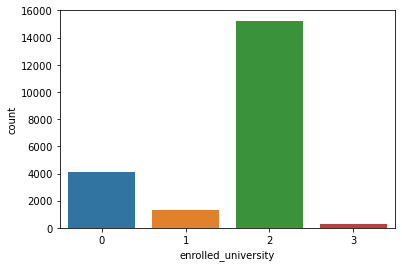

In [33]:
sns.countplot(x='enrolled_university',data=df)

# education_level

In [34]:
le_education_level = LabelEncoder().fit(df['education_level'])
df['education_level'] = le_education_level.transform(df['education_level'])
# Keep the record of labeling
dict(zip(le_education_level.classes_, le_education_level.transform(le_education_level.classes_)))

{'Graduate': 0,
 'High School': 1,
 'Masters': 2,
 'Phd': 3,
 'Primary School': 4,
 nan: 5}

In [35]:
df

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,3,0.920,1,0,2,0,STEM,>20,NaN,NaN,1,36,1.0
1,29725,1,0.776,1,1,2,0,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,3,0.624,2,1,0,0,STEM,5,NaN,NaN,never,83,0.0
3,33241,1,0.789,2,1,3,0,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,0,0.767,1,0,2,2,STEM,>20,50-99,Funded Startup,4,8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2124,1289,3,0.920,1,1,2,0,Humanities,16,NaN,Public Sector,4,15,0.5
2125,195,3,0.897,1,0,2,2,STEM,18,NaN,NaN,2,30,0.5
2126,31762,3,0.887,1,1,2,4,NaN,3,NaN,Pvt Ltd,never,18,0.5
2127,7873,3,0.804,1,0,0,1,NaN,7,100-500,Public Sector,1,84,0.5


# company_size

In [36]:
df.company_size.value_counts( dropna=False)

NaN          6294
50-99        3421
100-500      2885
10000+       2235
10/49        1640
1000-4999    1471
<10          1470
500-999       965
5000-9999     631
Name: company_size, dtype: int64

In [37]:
df['company_size'].replace(['<10','10/49', '50-99', '100-500', '500-999', '1000-4999', '5000-9999', '10000+',],
                             ['Startup','Small','Small','Medium','Medium','Large','Large','Large'],inplace=True)
df['company_size'] = df['company_size'].fillna(df['company_size'].value_counts().index[0]) # inpute with mode
CSizeLabelEncoder = LabelEncoder().fit(df['company_size'])
CSizeList = CSizeLabelEncoder.classes_
df['company_size'] = CSizeLabelEncoder.transform(df['company_size'])

# experience

In [38]:
df.experience.value_counts()

>20    3650
5      1573
4      1524
3      1470
6      1333
2      1202
7      1139
9      1089
10     1081
8       876
11      747
15      742
14      641
1       577
16      573
<1      572
12      543
13      452
17      377
19      332
18      304
20      165
Name: experience, dtype: int64

In [39]:
df['experience'].replace(['>20','<1'],[20,1],inplace=True)
df['experience'].fillna(df['experience'].value_counts().index[0],inplace=True) # fillna with mode
df['experience'] = [float(i) for i in df['experience']] # convert to float

# company_type

In [40]:
df.company_type.value_counts(dropna=False)

Pvt Ltd                10955
NaN                     6503
Funded Startup          1098
Public Sector           1081
Early Stage Startup      668
NGO                      574
Other                    133
Name: company_type, dtype: int64

In [41]:
# fillna as other
df['company_type'].fillna('Other' ,inplace=True)

In [42]:
le_company_type = LabelEncoder().fit(df['company_type'])
df['company_type'] = le_company_type.transform(df['company_type'])



# last_new_job

In [43]:
df.last_new_job.value_counts()

1        8887
>4       3632
2        3231
never    2597
3        1154
4        1147
Name: last_new_job, dtype: int64

In [44]:
df['last_new_job'].replace(['>4','never'],['4','0'],inplace=True)
df['last_new_job'].fillna(df['last_new_job'].value_counts().index[0],inplace=True)
df['last_new_job'] = [float(i) for i in df['last_new_job']]

# major discipline

In [45]:
df.major_discipline.value_counts( dropna=False)

STEM               16103
NaN                 2860
Humanities           749
Other                421
Business Degree      364
Arts                 270
No Major             245
Name: major_discipline, dtype: int64

In [46]:
df['major_discipline'].fillna('other' ,inplace=True)

In [47]:

le_major_discipline = LabelEncoder().fit(df['major_discipline'])
df['major_discipline'] = le_major_discipline.transform(df['major_discipline'])

In [48]:
df.dtypes

enrollee_id                 int64
city                        int32
city_development_index    float64
gender                      int32
relevent_experience         int32
enrolled_university         int32
education_level             int32
major_discipline            int32
experience                float64
company_size                int32
company_type                int32
last_new_job              float64
training_hours              int64
target                    float64
dtype: object

In [49]:
#note that enroll id doesnt provide information to the target

In [50]:
df = df.loc[:,df.columns != 'enrollee_id']

In [51]:
df.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,3,0.920,1,0,2,0,5,20.0,2,3,1.0,36,1.0
1,1,0.776,1,1,2,0,5,15.0,2,5,4.0,47,0.0
2,3,0.624,2,1,0,0,5,5.0,2,3,0.0,83,0.0
3,1,0.789,2,1,3,0,1,1.0,2,5,0.0,52,1.0
4,0,0.767,1,0,2,2,5,20.0,2,1,4.0,8,0.0


## Train and Testing Split

In [52]:
from sklearn.model_selection import train_test_split

X = df.loc[:, df.columns != 'target']
y = df.loc[:, df.columns == 'target']
X_train_rand, X_test_rand, y_train_rand, y_test_rand = train_test_split(X, y, test_size=0.2,random_state=42,
                                                    shuffle=True)

In [53]:
from sklearn.model_selection import StratifiedShuffleSplit

strat=StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)

for train_index,test_index in strat.split(df, df['education_level']):
    strat_train  = df.iloc[train_index]
    strat_test = df.iloc[test_index]

In [54]:
## compare the stratify vs random sampling from original proportions
## stratified sampling has almost close to original proportion while the random is skewed

orignial = pd.DataFrame(df.education_level.value_counts(normalize=True))\
                    .rename(columns={'education_level': 'Original'})

stratify = pd.DataFrame(strat_train.education_level.value_counts(normalize=True))\
                    .rename(columns={'education_level': 'Stratify'})

random =  pd.DataFrame(X_train_rand.education_level.value_counts(normalize=True))\
                    .rename(columns={'education_level': 'Random'})

error_summary = pd.concat([orignial, stratify,random], axis=1)
                                                                                                   
error_summary['stratfy_error%'] = (error_summary['Stratify']- error_summary['Original'] )/ error_summary['Stratify']
error_summary['random_error%'] = (error_summary['Random']- error_summary['Original'] )/ error_summary['Random']

error_summary
                    

,Original,Stratify,Random,stratfy_error%,random_error%
0,0.612031,0.612031,0.612172,0.000000,0.000230
2,0.230916,0.230916,0.230293,0.000000,-0.002703
1,0.103798,0.103750,0.104051,-0.000459,0.002437
3,0.022225,0.022273,0.022369,0.002137,0.006418
4,0.015896,0.015896,0.016122,0.000000,0.014057
5,0.015134,0.015134,0.014992,0.000000,-0.009488


In [55]:
df.target.value_counts()
df = df[df.target != 0.5]#I want to see if people try to stay or leave, no 0.5

In [56]:
print(df.target.value_counts(normalize=True))

0.0    0.750476
1.0    0.249524
Name: target, dtype: float64


In [57]:
X=df.loc[:, df.columns !='target']
y=df.loc[:, df.columns =='target']
oversample = SMOTE(random_state=42, sampling_strategy=0.6)
X_smote, Y_smote = oversample.fit_resample(X,y)

In [58]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train,y_test = train_test_split(X_smote, Y_smote, test_size=0.2,random_state=42, shuffle=True, stratify=Y_smote)

In [59]:
X_train.to_csv('X_train.csv',index=False)
X_test.to_csv('X_test.csv',index=False)
y_train.to_csv('y_train.csv',index=False)
y_test.to_csv('y_test.csv',index=False)

In [60]:
df_raw['stratefy_col'] = df_raw['gender'] + '_' + df_raw['target'].apply(lambda x: str(x))
df_raw.stratefy_col.value_counts()

Male_0.0      10209
Male_1.0       3012
Male_0.5       1460
Female_0.0      912
Female_1.0      326
Other_0.0       141
Female_0.5      137
Other_1.0        50
Other_0.5        24
Name: stratefy_col, dtype: int64

In [61]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [62]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [63]:
from sklearn.metrics import accuracy_score

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 81.35%
